## Import modules

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# Prepare Data
#### > Import apple stock data from AAPL.csv file, and separate it into X and y arrays
#### > Rescale data to make it more suitable for the machine learning model
#### > Split data into training and test sets, approximately 80% and 20% of the data respectively


In [13]:
# Load data
data = pd.read_csv('AAPL.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Compute 3 day moving average
data['MA_3'] = data['Close'].rolling(window=3).mean().shift(1)

X = data[['MA_3']].dropna().values
y = data['Close'].iloc[3:].values

#Rescale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#Split data
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define Simple RNN Model

In [14]:
def create_simple_RNN_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units, activation="relu", return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units, activation="relu", return_sequences=True))
    model.add(SimpleRNN(units))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create and Wrap the Model
#### > Define a tensorflow early stopping instance to be used by the model
#### > Create a model using the create_model function, wrapping it inside of a KerasRegressor, provided by the Keras library

In [15]:
#Define early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

#Wrap model
model_keras = KerasRegressor(
    model = create_simple_RNN_model,
    verbose = 1,
    epochs = 100,
    batch_size = 10,
    callbacks=[early_stopping],
    validation_split = 0.2
)

# Fit Model
#### > Define a parameter that will be used to find the best parameters in GridSearchCV
#### > Define a GridSearchCV model, using our previously-wrapped model as a base. This will be used to find the best combination of paramters
#### > Print the best results of the model

In [6]:
##Define parameter grid
param_grid = {
    'model__units': [30, 50, 100],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [10, 20, 50],
    'epochs': [10, 20, 30]
}

#Define and run model
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score']):
    print("%f (%f) with: %r" % (mean_score, scores, params))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.8092e-05 - val_loss: 3.6906e-04
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 1.0848e-05 - val_loss: 6.3877e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 8.5116e-06 - val_loss: 4.4426e-04
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 8.0317e-06 - val_loss: 5.7664e-04
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 6.7286e-06 - val_loss: 0.0010
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 6.9704e-06 - val_loss: 6.1595e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 5.4856e-06 - val_loss: 5.5454e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 6.4633e-06 - val_loss: 0.0012
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 5.0926e-06 - val_loss: 8.5566e-04
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.0916e-06 - val_loss: 0.0018
Restoring model weights from the end of the best epoch: 1.
292/292

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.6007e-05 - val_loss: 2.2459e-04
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 1.0640e-05 - val_loss: 3.0851e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 9.3007e-06 - val_loss: 6.0582e-04
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 7.1447e-06 - val_loss: 9.7269e-04
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4704e-06 - val_loss: 3.7128e-04
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1023e-06 - val_loss: 3.4656e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8268e-06 - val_loss: 7.6245e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.0128e-06 - val_loss: 4.9351e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0713e-06 - val_loss: 8.5334e-04
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 4.6709e-06 - val_loss: 0.0011
Restoring model weights from the end of the best epoch: 1.
292/29

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.5098e-06 - val_loss: 2.5884e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 7.0347e-07 - val_loss: 5.0687e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 7.5764e-07 - val_loss: 2.9810e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 6.3753e-07 - val_loss: 3.9512e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 5.7259e-07 - val_loss: 2.3108e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 5.5440e-07 - val_loss: 2.8162e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5172e-07 - val_loss: 3.1603e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3944e-07 - val_loss: 2.4303e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9157e-07 - val_loss: 3.3446e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3164e-07 - val_loss: 3.0319e-06
Restoring model weights from the end of the best epoch: 1.
2

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.8214e-05 - val_loss: 1.2042e-05
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 1.0433e-05 - val_loss: 2.6607e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 1.0567e-05 - val_loss: 4.3739e-04
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 9.1980e-06 - val_loss: 1.8408e-04
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1318e-06 - val_loss: 1.2552e-04
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 9.2750e-06 - val_loss: 3.0695e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 6.6798e-06 - val_loss: 9.5215e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 5.8529e-06 - val_loss: 6.2771e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 4.9907e-06 - val_loss: 2.3799e-04
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 5.1686e-06 - val_loss: 0.0012
Restoring model weights from the end of the best epoch: 1.

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7977e-05 - val_loss: 9.6605e-04
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 7.9535e-06 - val_loss: 5.6063e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9558e-06 - val_loss: 1.7470e-04
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 8.2863e-06 - val_loss: 5.2998e-04
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 5.4593e-06 - val_loss: 1.9310e-04
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 5.6572e-06 - val_loss: 9.2750e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 5.7520e-06 - val_loss: 9.3456e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 6.1661e-06 - val_loss: 0.0011
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 4.9782e-06 - val_loss: 0.0011
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9631e-06 - val_loss: 4.2212e-04
Restoring model weights from the end of the best epoch: 1.
292/2

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.9418e-06 - val_loss: 5.5788e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 8.7747e-07 - val_loss: 6.5982e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 7.4374e-07 - val_loss: 4.1725e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 6.5539e-07 - val_loss: 2.7707e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 6.3496e-07 - val_loss: 3.0124e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 5.9337e-07 - val_loss: 3.4431e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 6.1811e-07 - val_loss: 2.7800e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 5.2039e-07 - val_loss: 2.9690e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 5.6656e-07 - val_loss: 3.9507e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 5.6131e-07 - val_loss: 3.4222e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.9118e-05 - val_loss: 2.7613e-05
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 7.0971e-06 - val_loss: 1.2130e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5665e-06 - val_loss: 6.3408e-05
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 9.3303e-06 - val_loss: 5.3083e-05
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2765e-06 - val_loss: 3.1288e-04
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4997e-06 - val_loss: 2.5962e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 3.3104e-06 - val_loss: 1.8575e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 3.8056e-06 - val_loss: 4.8100e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7799e-06 - val_loss: 4.8283e-04
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7563e-06 - val_loss: 2.9387e-04
Restoring model weights from the end of the best epoch: 1.
292

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.8484e-05 - val_loss: 2.9399e-04
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3852e-06 - val_loss: 4.5133e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9230e-06 - val_loss: 1.0164e-04
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 5.6975e-06 - val_loss: 2.8680e-05
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8915e-06 - val_loss: 1.4903e-05
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2396e-06 - val_loss: 3.6460e-05
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 5.0326e-06 - val_loss: 2.2241e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 4.1680e-06 - val_loss: 1.3701e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 4.4771e-06 - val_loss: 1.2375e-04
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 4.9390e-06 - val_loss: 4.4511e-04
Restoring model weights from the end of the best epoch: 1.
2

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5913e-05 - val_loss: 3.8606e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5584e-07 - val_loss: 1.7944e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9945e-07 - val_loss: 4.0727e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7611e-07 - val_loss: 1.8022e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 7.6250e-07 - val_loss: 4.2352e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.5244e-07 - val_loss: 3.4437e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 6.1244e-07 - val_loss: 3.0194e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 6.4981e-07 - val_loss: 2.5566e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 5.7000e-07 - val_loss: 2.7050e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4273e-07 - val_loss: 2.5866e-06
Restoring model weights from the end of the best epoch: 1.
292

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1307e-04 - val_loss: 0.0027
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 5.4721e-05 - val_loss: 0.0021
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 4.3976e-05 - val_loss: 8.6377e-04
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 4.2262e-05 - val_loss: 7.7759e-04
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 4.1810e-05 - val_loss: 0.0013
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 3.4075e-05 - val_loss: 7.3440e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 3.4838e-05 - val_loss: 0.0012
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 3.0034e-05 - val_loss: 0.0013
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 3.1792e-05 - val_loss: 5.5354e-04
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 2.9400e-05 - val_loss: 8.4133e-04
Restoring model weights from the end of the best epoch: 3.
292/292 ━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0361e-04 - val_loss: 0.0020
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 5.4594e-05 - val_loss: 9.7666e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 4.9942e-05 - val_loss: 0.0016
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 4.4818e-05 - val_loss: 0.0012
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 4.0566e-05 - val_loss: 0.0019
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 3.6798e-05 - val_loss: 0.0018
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 3.6965e-05 - val_loss: 9.4610e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 3.3914e-05 - val_loss: 7.5031e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 3.3568e-05 - val_loss: 0.0010
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 3.1891e-05 - val_loss: 8.3747e-04
Restoring model weights from the end of the best epoch: 2.
292/292 ━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.5935e-05 - val_loss: 8.0700e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 1.2035e-05 - val_loss: 2.0937e-05
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 1.1768e-05 - val_loss: 4.1645e-05
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.1441e-05 - val_loss: 5.0258e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 1.0491e-05 - val_loss: 8.6722e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.0232e-05 - val_loss: 1.3661e-05
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 9.8992e-06 - val_loss: 2.3891e-05
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 9.4870e-06 - val_loss: 3.9830e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 9.2496e-06 - val_loss: 1.9393e-05
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 8.9917e-06 - val_loss: 6.6160e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3553e-04 - val_loss: 0.0025
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 7.0238e-05 - val_loss: 8.3558e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 5.8752e-05 - val_loss: 0.0013
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 5.4439e-05 - val_loss: 0.0010
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 4.7972e-05 - val_loss: 5.6619e-04
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 4.3786e-05 - val_loss: 2.8037e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 4.4651e-05 - val_loss: 6.4383e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 3.8325e-05 - val_loss: 2.6652e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 3.4130e-05 - val_loss: 5.4968e-04
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 3.3590e-05 - val_loss: 4.9126e-04
Restoring model weights from the end of the best epoch: 2.
292/2

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3660e-04 - val_loss: 0.0014
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 6.3584e-05 - val_loss: 0.0012
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 5.7373e-05 - val_loss: 5.3645e-04
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 5.0997e-05 - val_loss: 7.7321e-04
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 4.7620e-05 - val_loss: 9.1693e-04
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 4.2629e-05 - val_loss: 4.7835e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 3.5394e-05 - val_loss: 9.3029e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 3.5117e-05 - val_loss: 6.4694e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 3.2439e-05 - val_loss: 0.0010
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 3.4046e-05 - val_loss: 3.8886e-04
Restoring model weights from the end of the best epoch: 1.
292/2

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.0307e-05 - val_loss: 1.9478e-05
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 2.0361e-05 - val_loss: 2.2443e-05
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 1.9187e-05 - val_loss: 1.7626e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 1.7699e-05 - val_loss: 3.0491e-05
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 1.6409e-05 - val_loss: 1.8370e-05
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 1.5285e-05 - val_loss: 2.6967e-05
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.4403e-05 - val_loss: 5.1828e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 1.3495e-05 - val_loss: 1.1098e-05
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.2478e-05 - val_loss: 1.0332e-05
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.1784e-05 - val_loss: 1.4377e-05
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.9402e-04 - val_loss: 0.0033
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 1.0495e-04 - val_loss: 4.5471e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 7.7234e-05 - val_loss: 6.9352e-04
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 6.5942e-05 - val_loss: 8.4013e-04
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 6.0704e-05 - val_loss: 0.0016
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 5.9165e-05 - val_loss: 5.8999e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 4.5641e-05 - val_loss: 2.0008e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 3.8715e-05 - val_loss: 2.2832e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 3.6494e-05 - val_loss: 2.1687e-04
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3999e-05 - val_loss: 3.6946e-04
Restoring model weights from the end of the best epoch: 2.
292

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8552e-04 - val_loss: 0.0028
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 1.1019e-04 - val_loss: 0.0028
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 7.8510e-05 - val_loss: 0.0034
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 7.1034e-05 - val_loss: 0.0011
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 5.7521e-05 - val_loss: 0.0017
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 5.2577e-05 - val_loss: 8.5191e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 4.2487e-05 - val_loss: 7.8398e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 4.0999e-05 - val_loss: 5.7458e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 3.8138e-05 - val_loss: 7.8557e-04
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 3.3198e-05 - val_loss: 7.7189e-04
Restoring model weights from the end of the best epoch: 4.
292/292 ━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.7647e-05 - val_loss: 6.6713e-05
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4462e-05 - val_loss: 4.0777e-05
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 3.8529e-05 - val_loss: 2.2469e-05
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 3.4037e-05 - val_loss: 5.5803e-05
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 2.9611e-05 - val_loss: 1.1404e-05
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 2.5241e-05 - val_loss: 6.6404e-05
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 2.3056e-05 - val_loss: 6.7010e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 2.0379e-05 - val_loss: 1.3644e-05
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 1.7755e-05 - val_loss: 1.2757e-05
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 1.5952e-05 - val_loss: 3.8997e-06
Restoring model weights from the end of the best epoch

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.3280e-05 - val_loss: 5.7821e-04
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 1.3714e-05 - val_loss: 4.7787e-04
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.9037e-06 - val_loss: 6.7967e-04
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 9.4420e-06 - val_loss: 7.6930e-04
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 8.8645e-06 - val_loss: 9.6999e-04
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 7.4261e-06 - val_loss: 0.0012
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 7.0483e-06 - val_loss: 0.0010
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 8.3423e-06 - val_loss: 9.8998e-04
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 7.3098e-06 - val_loss: 9.3472e-04
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 6.7058e-06 - val_loss: 0.0014
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.663

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.3682e-05 - val_loss: 6.1654e-04
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 1.4644e-05 - val_loss: 4.1912e-04
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 1.0691e-05 - val_loss: 6.6426e-04
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 1.0209e-05 - val_loss: 0.0013
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 8.5903e-06 - val_loss: 4.1220e-04
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 1.0470e-05 - val_loss: 6.7565e-04
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6624e-06 - val_loss: 5.7927e-04
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 6.4990e-06 - val_loss: 0.0016
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 6.1492e-06 - val_loss: 0.0013
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 7.0878e-06 - val_loss: 0.0013
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 5.8196e

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.0948e-06 - val_loss: 3.5574e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 8.3338e-07 - val_loss: 2.7848e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 7.0417e-07 - val_loss: 1.7888e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 8.4329e-07 - val_loss: 4.5796e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 6.6710e-07 - val_loss: 3.6716e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 5.6917e-07 - val_loss: 3.0192e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 5.8112e-07 - val_loss: 3.7520e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 5.8144e-07 - val_loss: 1.9047e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 5.3937e-07 - val_loss: 3.1423e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2143e-07 - val_loss: 2.4765e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.0637e-05 - val_loss: 8.4621e-05
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 9.1750e-06 - val_loss: 3.0416e-04
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 8.8437e-06 - val_loss: 3.5099e-04
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 6.9546e-06 - val_loss: 4.9900e-04
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 7.2462e-06 - val_loss: 3.5143e-04
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 5.7772e-06 - val_loss: 2.2943e-04
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 5.0929e-06 - val_loss: 6.0613e-04
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7848e-06 - val_loss: 2.7167e-04
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3696e-06 - val_loss: 6.0937e-04
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.0175e-06 - val_loss: 1.9953e-04
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.0981e-05 - val_loss: 1.1812e-04
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 7.9102e-06 - val_loss: 1.1454e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0811e-05 - val_loss: 1.5759e-04
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 5.7199e-06 - val_loss: 6.5084e-05
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 5.4716e-06 - val_loss: 2.5479e-04
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 6.3524e-06 - val_loss: 1.5638e-04
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 5.2086e-06 - val_loss: 2.4701e-04
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 4.5904e-06 - val_loss: 2.5481e-04
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 4.7357e-06 - val_loss: 4.9656e-04
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 5.5230e-06 - val_loss: 4.2663e-04
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.3132e-06 - val_loss: 2.0763e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 6.6598e-07 - val_loss: 2.0133e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 7.5145e-07 - val_loss: 3.2048e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8524e-07 - val_loss: 2.3069e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 6.0654e-07 - val_loss: 2.8254e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 6.1096e-07 - val_loss: 3.9327e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 6.1750e-07 - val_loss: 3.3474e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 5.3841e-07 - val_loss: 2.3519e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 5.6646e-07 - val_loss: 3.8477e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 5.5216e-07 - val_loss: 1.9208e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.3671e-05 - val_loss: 3.1627e-04
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 8.0741e-06 - val_loss: 1.2951e-04
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 5.8925e-06 - val_loss: 1.9418e-04
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7008e-06 - val_loss: 3.9378e-05
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.8259e-06 - val_loss: 7.2629e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5623e-06 - val_loss: 1.5735e-04
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9510e-06 - val_loss: 1.4545e-05
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2518e-06 - val_loss: 6.7512e-04
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.7076e-06 - val_loss: 5.6158e-04
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 3.9523e-06 - val_loss: 4.5930e-04
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 4

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.4193e-05 - val_loss: 1.3374e-04
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 8.5347e-06 - val_loss: 2.3209e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 1.0331e-05 - val_loss: 9.4944e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 5.9120e-06 - val_loss: 5.7132e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 6.3029e-06 - val_loss: 8.4916e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 4.9088e-06 - val_loss: 7.2005e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 6.0886e-06 - val_loss: 1.4337e-05
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 4.9203e-06 - val_loss: 1.1945e-05
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 6.2349e-06 - val_loss: 1.0071e-04
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 4.7518e-06 - val_loss: 6.3710e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.4605e-06 - val_loss: 3.0652e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 6.9008e-07 - val_loss: 5.8869e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 9.5041e-07 - val_loss: 1.8896e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 6.6682e-07 - val_loss: 5.1960e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 6.8935e-07 - val_loss: 1.7531e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 6.0054e-07 - val_loss: 1.9849e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 5.8794e-07 - val_loss: 2.9311e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 5.5014e-07 - val_loss: 2.7483e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 5.2288e-07 - val_loss: 2.8240e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 5.6162e-07 - val_loss: 2.4659e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.0933e-05 - val_loss: 8.9110e-04
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 4.6935e-05 - val_loss: 0.0010
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 4.2308e-05 - val_loss: 5.3207e-04
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 3.6685e-05 - val_loss: 2.9506e-04
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 3.9723e-05 - val_loss: 4.9379e-04
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 4.0313e-05 - val_loss: 1.0037e-04
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 3.5721e-05 - val_loss: 6.2647e-04
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 3.1682e-05 - val_loss: 4.2089e-04
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 3.0881e-05 - val_loss: 0.0011
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 3.0496e-05 - val_loss: 3.7053e-04
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - los

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.2656e-04 - val_loss: 8.0894e-04
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 6.8718e-05 - val_loss: 0.0017
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 5.4299e-05 - val_loss: 0.0010
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 5.1770e-05 - val_loss: 8.2780e-04
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 4.8341e-05 - val_loss: 6.6974e-04
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 4.3242e-05 - val_loss: 0.0012
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 4.1925e-05 - val_loss: 6.7187e-04
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 4.2228e-05 - val_loss: 0.0010
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 4.0628e-05 - val_loss: 0.0012
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 3.5939e-05 - val_loss: 5.4975e-04
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 3.5977e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.9848e-05 - val_loss: 3.1419e-05
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 1.5388e-05 - val_loss: 1.6615e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 1.3878e-05 - val_loss: 1.8198e-05
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 1.4033e-05 - val_loss: 5.8971e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1.3259e-05 - val_loss: 2.1559e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.2875e-05 - val_loss: 5.6456e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 1.2370e-05 - val_loss: 1.9261e-05
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 1.1867e-05 - val_loss: 9.5287e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 1.1083e-05 - val_loss: 2.1558e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 1.1234e-05 - val_loss: 1.2660e-05
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4488e-04 - val_loss: 0.0018
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 8.1628e-05 - val_loss: 5.5438e-04
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 6.3734e-05 - val_loss: 1.6796e-04
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 5.7067e-05 - val_loss: 4.6354e-05
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 5.2743e-05 - val_loss: 1.5288e-04
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 4.9958e-05 - val_loss: 2.7878e-04
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 4.4541e-05 - val_loss: 2.2065e-04
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 4.3259e-05 - val_loss: 1.7981e-04
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 4.0594e-05 - val_loss: 3.2348e-04
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 4.0479e-05 - val_loss: 5.2338e-05
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step -

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.6157e-04 - val_loss: 0.0045
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 8.8642e-05 - val_loss: 0.0026
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 7.2134e-05 - val_loss: 0.0017
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 6.4946e-05 - val_loss: 8.0137e-04
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 5.9427e-05 - val_loss: 7.0075e-04
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 4.8300e-05 - val_loss: 0.0011
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 4.7642e-05 - val_loss: 0.0012
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 4.0756e-05 - val_loss: 0.0011
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 3.9886e-05 - val_loss: 7.0722e-04
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 3.6514e-05 - val_loss: 0.0015
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 3.3891e-05 - val_

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.8569e-05 - val_loss: 1.4382e-05
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 2.1332e-05 - val_loss: 1.9430e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 1.9481e-05 - val_loss: 1.5774e-05
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 1.7593e-05 - val_loss: 1.8409e-05
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 1.6575e-05 - val_loss: 1.4210e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 1.4873e-05 - val_loss: 2.0465e-05
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.3620e-05 - val_loss: 5.8473e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 1.2936e-05 - val_loss: 1.4386e-05
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.2115e-05 - val_loss: 2.1121e-05
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 1.1490e-05 - val_loss: 2.2891e-05
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.9171e-04 - val_loss: 0.0060
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1.0893e-04 - val_loss: 0.0019
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 8.4663e-05 - val_loss: 9.3500e-04
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 6.9464e-05 - val_loss: 0.0035
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 5.8288e-05 - val_loss: 0.0017
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 5.4733e-05 - val_loss: 7.1835e-04
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 4.3208e-05 - val_loss: 0.0010
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 3.9921e-05 - val_loss: 9.9772e-04
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 3.8559e-05 - val_loss: 4.3714e-04
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 3.4459e-05 - val_loss: 0.0012
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 3.1135e-05 - 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8823e-04 - val_loss: 0.0052
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 1.0847e-04 - val_loss: 0.0025
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 7.6923e-05 - val_loss: 0.0014
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 6.8069e-05 - val_loss: 7.3733e-04
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 6.0637e-05 - val_loss: 2.4592e-04
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 5.6010e-05 - val_loss: 7.5378e-04
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2239e-05 - val_loss: 3.7554e-04
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 3.6637e-05 - val_loss: 4.9792e-04
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 3.4780e-05 - val_loss: 7.3027e-04
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 3.2277e-05 - val_loss: 3.9871e-04
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 2.6

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 5.7920e-05 - val_loss: 1.8523e-05
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 3.9446e-05 - val_loss: 3.6153e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 3.4175e-05 - val_loss: 1.9064e-05
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 3.0715e-05 - val_loss: 4.1615e-05
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 2.6882e-05 - val_loss: 1.2674e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 2.3918e-05 - val_loss: 3.5505e-05
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 2.1337e-05 - val_loss: 1.0249e-05
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.8766e-05 - val_loss: 4.1863e-05
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 1.6636e-05 - val_loss: 1.6655e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 1.4791e-05 - val_loss: 3.0121e-05
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.8864e-05 - val_loss: 1.9160e-04
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7210e-05 - val_loss: 6.0516e-05
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8990e-06 - val_loss: 4.2470e-04
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.4859e-06 - val_loss: 1.5320e-04
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.1093e-06 - val_loss: 5.3132e-04
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.8699e-06 - val_loss: 7.4859e-04
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.3731e-06 - val_loss: 2.5012e-04
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5416e-06 - val_loss: 7.1707e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.6174e-06 - val_loss: 0.0017
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4371e-06 - val_loss: 6.2690e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 7.2354e-06 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.1617e-05 - val_loss: 0.0011
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8557e-06 - val_loss: 9.3942e-04
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 7.4348e-06 - val_loss: 8.5789e-04
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 8.4242e-06 - val_loss: 6.8939e-04
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 7.3602e-06 - val_loss: 0.0011
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 5.5558e-06 - val_loss: 0.0012
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 6.6399e-06 - val_loss: 8.3390e-04
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 6.9885e-06 - val_loss: 7.1174e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 4.7662e-06 - val_loss: 9.2753e-04
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 6.2067e-06 - val_loss: 0.0012
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 4.6332e

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.0397e-06 - val_loss: 1.9004e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 7.1512e-07 - val_loss: 2.8524e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 6.3940e-07 - val_loss: 3.2979e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 6.9942e-07 - val_loss: 4.7052e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 6.4267e-07 - val_loss: 2.9469e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 5.4987e-07 - val_loss: 3.6488e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 5.8055e-07 - val_loss: 3.1342e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 5.5059e-07 - val_loss: 2.9036e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 5.3554e-07 - val_loss: 2.1630e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 5.6177e-07 - val_loss: 3.4257e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.7753e-05 - val_loss: 1.2847e-05
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 1.4027e-05 - val_loss: 2.2026e-04
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 8.1008e-06 - val_loss: 9.7981e-04
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 7.7083e-06 - val_loss: 3.7292e-04
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 8.1696e-06 - val_loss: 7.0390e-04
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 9.8259e-06 - val_loss: 8.5932e-04
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 7.0971e-06 - val_loss: 6.4548e-04
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 6.9653e-06 - val_loss: 4.3940e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 6.2469e-06 - val_loss: 0.0013
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 7.0758e-06 - val_loss: 8.3877e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step -

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.7678e-05 - val_loss: 5.0001e-04
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 9.5080e-06 - val_loss: 7.6291e-04
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 9.7016e-06 - val_loss: 5.0483e-04
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 9.2685e-06 - val_loss: 4.4298e-04
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 6.1702e-06 - val_loss: 3.8618e-04
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 6.5340e-06 - val_loss: 5.9410e-04
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 6.1358e-06 - val_loss: 6.1886e-04
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 7.5299e-06 - val_loss: 3.0353e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 6.2787e-06 - val_loss: 9.7010e-04
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 5.1992e-06 - val_loss: 5.5077e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 5.9492e-06 - val_loss: 3.9767e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 7.4273e-07 - val_loss: 2.2720e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 7.5399e-07 - val_loss: 1.9178e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 8.5224e-07 - val_loss: 3.6454e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 7.2293e-07 - val_loss: 1.9075e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 5.9552e-07 - val_loss: 2.5266e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 5.9293e-07 - val_loss: 3.8536e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 5.7179e-07 - val_loss: 2.3415e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 5.7842e-07 - val_loss: 2.3802e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 5.4676e-07 - val_loss: 3.3587e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.8526e-05 - val_loss: 9.2725e-05
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 7.7893e-06 - val_loss: 3.6614e-04
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8943e-06 - val_loss: 2.0540e-05
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 5.8397e-06 - val_loss: 4.0872e-04
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 5.8840e-06 - val_loss: 2.2075e-04
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 5.0723e-06 - val_loss: 1.5284e-05
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 3.6759e-06 - val_loss: 8.9382e-05
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 3.9761e-06 - val_loss: 3.0055e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 3.7049e-06 - val_loss: 4.9341e-04
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 4.4296e-06 - val_loss: 1.2708e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.6934e-05 - val_loss: 1.4746e-04
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 8.4700e-06 - val_loss: 6.7098e-05
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 7.5917e-06 - val_loss: 3.1736e-04
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 5.1356e-06 - val_loss: 1.4506e-04
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 4.0822e-06 - val_loss: 0.0015
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 7.6531e-06 - val_loss: 0.0012
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 3.8915e-06 - val_loss: 9.4627e-05
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 4.4590e-06 - val_loss: 2.0040e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 5.6917e-06 - val_loss: 7.4256e-04
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 4.0231e-06 - val_loss: 4.3072e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - los

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3032e-05 - val_loss: 2.6020e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 6.5073e-07 - val_loss: 1.6722e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 8.3614e-07 - val_loss: 2.5202e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 8.8274e-07 - val_loss: 1.6565e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 8.3482e-07 - val_loss: 3.4260e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 7.5426e-07 - val_loss: 2.5035e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 6.1252e-07 - val_loss: 2.5532e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 5.4614e-07 - val_loss: 2.7328e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 5.5891e-07 - val_loss: 3.1812e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 5.2671e-07 - val_loss: 2.3931e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2746e-04 - val_loss: 0.0023
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 5.7041e-05 - val_loss: 0.0011
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 4.8184e-05 - val_loss: 0.0011
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 4.8751e-05 - val_loss: 5.2995e-04
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 4.5432e-05 - val_loss: 5.9110e-04
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 4.2761e-05 - val_loss: 3.6974e-04
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 3.8551e-05 - val_loss: 5.0947e-04
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 3.6533e-05 - val_loss: 3.2384e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 3.8341e-05 - val_loss: 5.0040e-04
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 3.2482e-05 - val_loss: 6.5081e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 3

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3349e-04 - val_loss: 0.0043
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 7.5403e-05 - val_loss: 9.4990e-04
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 6.0997e-05 - val_loss: 0.0014
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 5.5819e-05 - val_loss: 0.0017
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 4.6892e-05 - val_loss: 0.0012
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 4.6960e-05 - val_loss: 8.8830e-04
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 3.9678e-05 - val_loss: 0.0017
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 3.7189e-05 - val_loss: 7.2444e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 3.8325e-05 - val_loss: 9.8023e-04
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 3.6815e-05 - val_loss: 3.5325e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 3.4835e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.4356e-05 - val_loss: 5.1847e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 1.7276e-05 - val_loss: 2.7269e-05
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 1.6438e-05 - val_loss: 7.3045e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.5428e-05 - val_loss: 1.3178e-05
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 1.4967e-05 - val_loss: 8.7755e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.4597e-05 - val_loss: 4.9834e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.2157e-05 - val_loss: 3.0422e-05
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 1.3293e-05 - val_loss: 2.1085e-05
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 1.2242e-05 - val_loss: 2.2974e-05
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1.1692e-05 - val_loss: 1.1874e-05
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3349e-04 - val_loss: 0.0016
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 7.1584e-05 - val_loss: 6.6380e-04
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 6.1994e-05 - val_loss: 0.0011
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 4.8740e-05 - val_loss: 0.0015
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 4.3724e-05 - val_loss: 5.0003e-04
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 4.1717e-05 - val_loss: 8.8768e-04
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 4.1384e-05 - val_loss: 0.0011
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 3.8247e-05 - val_loss: 9.9717e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 3.8162e-05 - val_loss: 3.7833e-04
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 3.2148e-05 - val_loss: 6.9104e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 2.915

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.5472e-04 - val_loss: 0.0022
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 7.9889e-05 - val_loss: 0.0013
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 6.8125e-05 - val_loss: 0.0020
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 5.6047e-05 - val_loss: 8.4952e-04
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 5.4213e-05 - val_loss: 9.4494e-04
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 5.4103e-05 - val_loss: 0.0014
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 4.4692e-05 - val_loss: 0.0018
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 4.2747e-05 - val_loss: 0.0017
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 3.9053e-05 - val_loss: 0.0017
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 3.5441e-05 - val_loss: 8.7942e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 3.3400e-05 - val_

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.4122e-05 - val_loss: 1.2841e-05
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 1.8027e-05 - val_loss: 1.8976e-05
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 1.6650e-05 - val_loss: 5.9353e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 1.5843e-05 - val_loss: 2.9597e-05
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 1.5192e-05 - val_loss: 7.1900e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 1.3952e-05 - val_loss: 1.4877e-05
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.3497e-05 - val_loss: 5.5333e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 1.2525e-05 - val_loss: 1.6197e-05
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 1.1384e-05 - val_loss: 3.1694e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1110e-05 - val_loss: 9.6174e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1246e-04 - val_loss: 0.0032
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 1.2103e-04 - val_loss: 0.0029
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 9.7052e-05 - val_loss: 0.0030
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 6.9780e-05 - val_loss: 0.0015
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 5.8792e-05 - val_loss: 6.9083e-04
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 5.5814e-05 - val_loss: 0.0015
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 4.4988e-05 - val_loss: 7.9846e-04
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 4.1894e-05 - val_loss: 7.3369e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 3.6938e-05 - val_loss: 8.9068e-04
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 3.3007e-05 - val_loss: 0.0010
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 2.9865e-05 - 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.1143e-04 - val_loss: 0.0030
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 1.2121e-04 - val_loss: 0.0029
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 8.8145e-05 - val_loss: 0.0021
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 6.7010e-05 - val_loss: 0.0025
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 6.0005e-05 - val_loss: 0.0019
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 5.2400e-05 - val_loss: 0.0017
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 4.3811e-05 - val_loss: 0.0012
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 4.1305e-05 - val_loss: 0.0012
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 3.6326e-05 - val_loss: 0.0010
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 3.3657e-05 - val_loss: 9.1825e-04
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 2.9255e-05 - val_loss: 9.

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2610e-05 - val_loss: 2.5099e-05
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 2.6392e-05 - val_loss: 3.9869e-05
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 2.3974e-05 - val_loss: 1.1053e-05
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 2.0913e-05 - val_loss: 4.0077e-05
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 1.8667e-05 - val_loss: 4.7417e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 1.6589e-05 - val_loss: 1.9477e-05
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 1.5318e-05 - val_loss: 6.7944e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 1.3713e-05 - val_loss: 2.2874e-05
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 1.2202e-05 - val_loss: 1.0057e-05
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 1.0745e-05 - val_loss: 1.2174e-05
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7182e-05 - val_loss: 0.0011
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5771e-05 - val_loss: 7.8773e-04
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3607e-05 - val_loss: 0.0014
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0800e-05 - val_loss: 5.3634e-04
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5524e-05 - val_loss: 0.0013
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7001e-06 - val_loss: 0.0014
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2073e-06 - val_loss: 0.0014
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4888e-06 - val_loss: 0.0015
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9699e-06 - val_loss: 0.0015
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6869e-06 - val_loss: 0.0014
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ep

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8190e-05 - val_loss: 7.6018e-04
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1812e-05 - val_loss: 0.0013
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4841e-06 - val_loss: 9.9662e-04
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7799e-06 - val_loss: 0.0016
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0235e-06 - val_loss: 0.0012
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 8.6177e-06 - val_loss: 0.0011
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2987e-06 - val_loss: 9.7150e-04
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 6.0933e-06 - val_loss: 0.0013
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0745e-06 - val_loss: 7.4148e-04
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 7.2261e-06 - val_loss: 0.0013
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8542e-06 - val_loss: 2.9475e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 5.8831e-07 - val_loss: 2.2899e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2722e-07 - val_loss: 3.1822e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4324e-07 - val_loss: 2.7711e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9134e-07 - val_loss: 3.8189e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2642e-07 - val_loss: 3.6156e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1117e-07 - val_loss: 1.9230e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6331e-07 - val_loss: 2.7633e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3355e-07 - val_loss: 2.8108e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7332e-07 - val_loss: 2.7842e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.1477e-05 - val_loss: 4.0467e-04
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 8.3562e-06 - val_loss: 5.4371e-04
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 7.0312e-06 - val_loss: 3.5754e-04
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 6.9147e-06 - val_loss: 7.6375e-04
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 5.6766e-06 - val_loss: 8.4396e-04
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 5.6196e-06 - val_loss: 8.1070e-04
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 5.0979e-06 - val_loss: 8.6127e-04
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 4.0256e-06 - val_loss: 0.0015
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6491e-06 - val_loss: 0.0011
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 4.1295e-06 - val_loss: 0.0011
Restoring model weights from the end of the best epoch: 1.
146/146

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3021e-05 - val_loss: 8.5681e-05
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 6.9492e-06 - val_loss: 4.4326e-04
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 6.7491e-06 - val_loss: 6.4273e-04
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 5.2437e-06 - val_loss: 3.5880e-04
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 4.9424e-06 - val_loss: 6.6822e-04
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 6.4113e-06 - val_loss: 6.4711e-04
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6664e-06 - val_loss: 5.9397e-04
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9397e-06 - val_loss: 9.9694e-04
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1149e-06 - val_loss: 7.5509e-04
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 4.3296e-06 - val_loss: 3.4170e-04
Restoring model weights from the end of the best epoch: 1.

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.2248e-06 - val_loss: 3.0258e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 6.7977e-07 - val_loss: 2.3728e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 5.5467e-07 - val_loss: 2.6519e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 6.4312e-07 - val_loss: 1.6630e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 7.5636e-07 - val_loss: 1.7703e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 6.5472e-07 - val_loss: 3.0555e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 7.1056e-07 - val_loss: 1.6689e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 8.2289e-07 - val_loss: 2.8738e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 6.3451e-07 - val_loss: 2.3152e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 5.7485e-07 - val_loss: 2.8818e-06
Restoring model weights from the end of the best ep

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2937e-05 - val_loss: 1.9213e-04
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3903e-06 - val_loss: 1.2804e-05
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5862e-06 - val_loss: 1.5904e-04
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0722e-06 - val_loss: 4.0773e-04
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3273e-06 - val_loss: 4.2026e-04
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4631e-06 - val_loss: 2.9334e-04
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3068e-06 - val_loss: 5.9290e-04
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0167e-06 - val_loss: 3.1922e-04
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7366e-06 - val_loss: 1.1380e-04
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6900e-06 - val_loss: 0.0012
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7592e-05 - val_loss: 9.6325e-05
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0087e-05 - val_loss: 1.4296e-04
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9381e-06 - val_loss: 5.4227e-05
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5028e-06 - val_loss: 1.4572e-04
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9372e-06 - val_loss: 2.9592e-04
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4142e-06 - val_loss: 2.4621e-05
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6628e-06 - val_loss: 3.2726e-05
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0569e-06 - val_loss: 5.5817e-04
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1058e-06 - val_loss: 1.0463e-04
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9457e-06 - val_loss: 5.0748e-04
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7447e-05 - val_loss: 2.6570e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1785e-07 - val_loss: 2.8488e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4068e-07 - val_loss: 3.8383e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5368e-07 - val_loss: 1.6579e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9432e-07 - val_loss: 2.8006e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0324e-07 - val_loss: 3.5725e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4268e-07 - val_loss: 2.3986e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1689e-07 - val_loss: 3.3271e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1796e-07 - val_loss: 1.6466e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1878e-07 - val_loss: 1.9703e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2990e-04 - val_loss: 0.0070
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 7.3638e-05 - val_loss: 0.0027
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 5.7294e-05 - val_loss: 0.0035
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 4.8190e-05 - val_loss: 0.0015
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 4.8192e-05 - val_loss: 0.0025
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 4.0268e-05 - val_loss: 0.0018
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 3.7823e-05 - val_loss: 9.9556e-04
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 4.0958e-05 - val_loss: 0.0024
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 3.7759e-05 - val_loss: 0.0014
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 3.5708e-05 - val_loss: 0.0023
Restoring model weights from the end of the best epoch: 4.
146/146 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1133e-04 - val_loss: 0.0025
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 6.0032e-05 - val_loss: 9.3831e-04
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 5.4019e-05 - val_loss: 0.0016
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 4.8379e-05 - val_loss: 0.0014
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 4.2756e-05 - val_loss: 0.0014
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 4.0664e-05 - val_loss: 0.0018
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 3.8955e-05 - val_loss: 9.4136e-04
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 4.0172e-05 - val_loss: 0.0022
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 3.7583e-05 - val_loss: 0.0028
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8732e-05 - val_loss: 6.9079e-04
Restoring model weights from the end of the best epoch: 2.
146/146 ━━━━━━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0921e-05 - val_loss: 4.7512e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 1.3759e-05 - val_loss: 3.8680e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.2967e-05 - val_loss: 8.7744e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.2537e-05 - val_loss: 5.0138e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 1.2175e-05 - val_loss: 5.6073e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1.2219e-05 - val_loss: 8.8127e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 1.1662e-05 - val_loss: 1.4711e-05
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1.1983e-05 - val_loss: 5.0223e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.1198e-05 - val_loss: 6.2780e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 1.0468e-05 - val_loss: 4.9272e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4994e-04 - val_loss: 0.0037
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 9.9992e-05 - val_loss: 0.0035
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 7.9022e-05 - val_loss: 0.0034
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 7.2267e-05 - val_loss: 0.0021
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 6.6683e-05 - val_loss: 0.0029
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 5.9796e-05 - val_loss: 0.0019
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 5.8302e-05 - val_loss: 0.0020
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 5.8441e-05 - val_loss: 0.0017
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 5.5700e-05 - val_loss: 0.0018
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 5.6465e-05 - val_loss: 0.0025
Restoring model weights from the end of the best epoch: 4.
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3972e-04 - val_loss: 0.0051
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 8.1816e-05 - val_loss: 0.0033
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 6.8724e-05 - val_loss: 0.0028
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 6.3536e-05 - val_loss: 0.0011
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 6.0438e-05 - val_loss: 0.0016
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 5.4159e-05 - val_loss: 0.0016
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 4.5160e-05 - val_loss: 0.0017
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 4.5554e-05 - val_loss: 0.0015
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 4.5331e-05 - val_loss: 0.0018
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 4.0371e-05 - val_loss: 6.3610e-04
Restoring model weights from the end of the best epoch: 4.
146/146 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7128e-05 - val_loss: 3.4537e-05
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 1.9158e-05 - val_loss: 3.1976e-05
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 1.8857e-05 - val_loss: 3.9813e-05
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.8626e-05 - val_loss: 4.3826e-05
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.8263e-05 - val_loss: 3.2289e-05
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.7361e-05 - val_loss: 4.4813e-05
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 1.7014e-05 - val_loss: 3.6821e-05
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.5775e-05 - val_loss: 2.5884e-05
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 1.5764e-05 - val_loss: 1.2271e-05
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 1.4663e-05 - val_loss: 1.2781e-05
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1070e-04 - val_loss: 0.0028
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 1.2131e-04 - val_loss: 0.0030
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 9.8227e-05 - val_loss: 0.0016
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 8.8117e-05 - val_loss: 0.0011
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 7.8739e-05 - val_loss: 8.0879e-04
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 6.8075e-05 - val_loss: 8.2869e-04
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 6.4465e-05 - val_loss: 0.0014
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 6.8936e-05 - val_loss: 5.9786e-04
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 5.3947e-05 - val_loss: 2.8661e-04
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 6.2159e-05 - val_loss: 0.0016
Restoring model weights from the end of the best epoch: 9.
146/146 ━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1372e-04 - val_loss: 0.0017
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 1.2957e-04 - val_loss: 0.0017
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 1.1040e-04 - val_loss: 0.0018
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 8.8403e-05 - val_loss: 7.2574e-04
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 8.1420e-05 - val_loss: 6.7857e-04
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 7.7816e-05 - val_loss: 7.0538e-04
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 6.5225e-05 - val_loss: 0.0011
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 6.0742e-05 - val_loss: 8.0310e-04
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 5.6198e-05 - val_loss: 1.4155e-04
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 6.0144e-05 - val_loss: 8.4102e-04
Restoring model weights from the end of the best epoch: 9.
146/146 ━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.6346e-05 - val_loss: 7.4449e-05
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 4.1244e-05 - val_loss: 4.3321e-05
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 3.7162e-05 - val_loss: 2.9535e-05
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 3.4253e-05 - val_loss: 5.1317e-05
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 3.2357e-05 - val_loss: 6.1136e-05
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 3.0619e-05 - val_loss: 3.3475e-05
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8466e-05 - val_loss: 4.5907e-05
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 2.6227e-05 - val_loss: 3.2884e-05
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 2.4600e-05 - val_loss: 3.3777e-05
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 2.2975e-05 - val_loss: 6.4519e-05
Restoring model weights from the end of the best epoch

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.8778e-05 - val_loss: 4.4513e-04
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2295e-05 - val_loss: 6.8278e-04
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 8.6923e-06 - val_loss: 6.4637e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 1.0078e-05 - val_loss: 6.7693e-04
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 6.2927e-06 - val_loss: 5.9416e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4134e-06 - val_loss: 0.0013
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 6.4498e-06 - val_loss: 7.2351e-04
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 5.7748e-06 - val_loss: 0.0011
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 5.2261e-06 - val_loss: 0.0015
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1257e-06 - val_loss: 0.0011
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 6.0085e-06 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6003e-05 - val_loss: 8.0600e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1656e-05 - val_loss: 4.2150e-04
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5407e-05 - val_loss: 5.2828e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2027e-05 - val_loss: 6.6201e-04
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9816e-06 - val_loss: 4.8900e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6859e-06 - val_loss: 9.6478e-04
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7568e-06 - val_loss: 9.4772e-04
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6208e-06 - val_loss: 0.0017
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 6.6659e-06 - val_loss: 6.5021e-04
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9992e-06 - val_loss: 9.9027e-04
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 8.9155e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.1509e-06 - val_loss: 3.4952e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9171e-07 - val_loss: 2.5221e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8071e-07 - val_loss: 4.4351e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7389e-07 - val_loss: 3.3126e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1016e-07 - val_loss: 2.3026e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5549e-07 - val_loss: 1.7355e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2727e-07 - val_loss: 2.7396e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3256e-07 - val_loss: 2.6177e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3512e-07 - val_loss: 2.8330e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6269e-07 - val_loss: 2.6952e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7051e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7610e-05 - val_loss: 1.4846e-04
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 8.7708e-06 - val_loss: 3.3192e-04
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 8.9074e-06 - val_loss: 4.5789e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 4.9448e-06 - val_loss: 3.3671e-04
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1929e-06 - val_loss: 7.5592e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 6.1202e-06 - val_loss: 0.0014
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 4.4652e-06 - val_loss: 0.0013
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 4.9934e-06 - val_loss: 0.0012
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 4.7384e-06 - val_loss: 0.0012
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 4.5576e-06 - val_loss: 6.9980e-04
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 5.0080e

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3784e-05 - val_loss: 6.0447e-04
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 8.1219e-06 - val_loss: 2.5725e-04
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0855e-06 - val_loss: 4.7286e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 5.5910e-06 - val_loss: 3.3513e-04
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9727e-06 - val_loss: 3.9122e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3031e-06 - val_loss: 5.7360e-04
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6579e-06 - val_loss: 3.3497e-04
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7424e-06 - val_loss: 0.0012
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4820e-06 - val_loss: 8.5218e-04
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0051e-06 - val_loss: 0.0011
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6319e-06 - 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.7744e-06 - val_loss: 2.8787e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 5.5655e-07 - val_loss: 2.8984e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 5.7007e-07 - val_loss: 3.5096e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 6.1548e-07 - val_loss: 1.8445e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 7.8326e-07 - val_loss: 2.1545e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 6.2279e-07 - val_loss: 2.1483e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 6.8771e-07 - val_loss: 2.7996e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 5.9019e-07 - val_loss: 1.8599e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 5.8838e-07 - val_loss: 2.9864e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 5.4793e-07 - val_loss: 2.0231e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7973e-05 - val_loss: 9.5454e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9452e-06 - val_loss: 1.2620e-04
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9922e-06 - val_loss: 1.3555e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2485e-06 - val_loss: 3.9112e-04
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2700e-06 - val_loss: 3.0898e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8671e-06 - val_loss: 5.0873e-04
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5024e-06 - val_loss: 1.0477e-04
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6291e-06 - val_loss: 3.3021e-04
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3673e-06 - val_loss: 2.3433e-04
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4442e-06 - val_loss: 4.6899e-04
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2975e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6347e-05 - val_loss: 1.6808e-04
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4434e-06 - val_loss: 1.5538e-05
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3183e-06 - val_loss: 3.9663e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3059e-06 - val_loss: 2.0620e-04
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8514e-06 - val_loss: 3.7828e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2630e-06 - val_loss: 7.5137e-04
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3310e-06 - val_loss: 3.6623e-04
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0359e-06 - val_loss: 1.2203e-04
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5192e-06 - val_loss: 1.3862e-05
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7234e-06 - val_loss: 1.1592e-05
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9457e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2467e-05 - val_loss: 2.3055e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5722e-07 - val_loss: 3.6675e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4113e-07 - val_loss: 1.8169e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5149e-07 - val_loss: 3.7804e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9871e-07 - val_loss: 2.8053e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1202e-07 - val_loss: 2.2225e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7260e-07 - val_loss: 4.5950e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2874e-07 - val_loss: 4.4337e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7043e-07 - val_loss: 2.2031e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7271e-07 - val_loss: 1.8072e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8740e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6233e-04 - val_loss: 0.0059
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8234e-05 - val_loss: 0.0028
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0625e-05 - val_loss: 0.0029
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 6.0406e-05 - val_loss: 0.0018
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 5.4395e-05 - val_loss: 0.0023
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 4.9633e-05 - val_loss: 0.0016
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 4.3949e-05 - val_loss: 0.0016
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 4.3479e-05 - val_loss: 0.0021
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 4.1152e-05 - val_loss: 0.0016
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 3.6656e-05 - val_loss: 8.7151e-04
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 4.0599e-05 - val_loss: 0.0014

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3431e-04 - val_loss: 0.0038
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 7.4305e-05 - val_loss: 0.0025
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9061e-05 - val_loss: 0.0036
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8783e-05 - val_loss: 0.0020
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 6.5126e-05 - val_loss: 0.0029
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 6.3622e-05 - val_loss: 0.0024
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 5.3027e-05 - val_loss: 0.0018
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 5.6721e-05 - val_loss: 0.0018
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 5.2611e-05 - val_loss: 0.0011
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 4.8142e-05 - val_loss: 0.0021
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4200e-05 - val_loss: 0.0020
Epoc

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3028e-05 - val_loss: 2.2576e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 1.6371e-05 - val_loss: 3.4062e-05
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.5994e-05 - val_loss: 2.9753e-05
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 1.5691e-05 - val_loss: 4.6002e-05
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 1.5047e-05 - val_loss: 2.9909e-05
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4947e-05 - val_loss: 3.1232e-05
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 1.4434e-05 - val_loss: 2.6648e-05
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4336e-05 - val_loss: 3.1621e-05
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3775e-05 - val_loss: 3.4478e-05
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.3611e-05 - val_loss: 1.1392e-05
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - l

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3487e-04 - val_loss: 0.0028
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 6.8989e-05 - val_loss: 0.0013
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 6.1255e-05 - val_loss: 9.9240e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1827e-05 - val_loss: 0.0012
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6915e-05 - val_loss: 8.4434e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7791e-05 - val_loss: 0.0010
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 4.3338e-05 - val_loss: 3.0078e-04
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9018e-05 - val_loss: 0.0011
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 4.6412e-05 - val_loss: 4.5844e-04
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 3.8808e-05 - val_loss: 0.0010
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 4.0309e-05 - val_loss

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7477e-04 - val_loss: 0.0047
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 9.5070e-05 - val_loss: 0.0013
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 8.2544e-05 - val_loss: 9.9784e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 6.1108e-05 - val_loss: 2.8090e-04
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 6.5150e-05 - val_loss: 7.7819e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 5.3490e-05 - val_loss: 0.0011
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 5.1034e-05 - val_loss: 0.0012
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 5.0219e-05 - val_loss: 4.1391e-04
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 4.8129e-05 - val_loss: 3.2186e-04
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 4.7899e-05 - val_loss: 4.3158e-04
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 4.806

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9583e-05 - val_loss: 2.8121e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 2.6461e-05 - val_loss: 4.2703e-05
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 2.6020e-05 - val_loss: 3.1425e-05
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 2.4977e-05 - val_loss: 5.1334e-05
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 2.3988e-05 - val_loss: 2.0752e-05
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 2.3044e-05 - val_loss: 3.7495e-05
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 2.2389e-05 - val_loss: 3.4540e-05
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 2.1898e-05 - val_loss: 3.9556e-05
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 2.0255e-05 - val_loss: 3.9012e-05
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 2.0061e-05 - val_loss: 2.8143e-05
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0229e-04 - val_loss: 0.0016
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3386e-04 - val_loss: 0.0031
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 1.0353e-04 - val_loss: 0.0013
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3110e-05 - val_loss: 0.0012
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9926e-05 - val_loss: 2.8633e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2515e-05 - val_loss: 5.8222e-04
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 5.8285e-05 - val_loss: 4.6441e-04
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5292e-05 - val_loss: 3.8637e-04
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6647e-05 - val_loss: 5.8869e-04
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5718e-05 - val_loss: 4.2906e-04
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8551e-05 - val_loss

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.4091e-04 - val_loss: 0.0043
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3003e-04 - val_loss: 0.0028
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 1.1318e-04 - val_loss: 0.0022
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3857e-05 - val_loss: 0.0020
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1902e-05 - val_loss: 4.8295e-04
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8651e-05 - val_loss: 9.4834e-04
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0793e-05 - val_loss: 5.1569e-04
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8194e-05 - val_loss: 9.5702e-04
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7742e-05 - val_loss: 0.0013
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7551e-05 - val_loss: 0.0011
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9806e-05 - val_loss: 0.0012
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.4608e-05 - val_loss: 7.5201e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 4.0675e-05 - val_loss: 4.0520e-05
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 3.8231e-05 - val_loss: 4.7569e-05
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5575e-05 - val_loss: 5.9147e-05
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 3.2366e-05 - val_loss: 4.5335e-05
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1807e-05 - val_loss: 4.0982e-05
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8682e-05 - val_loss: 5.5345e-05
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 2.7342e-05 - val_loss: 3.8657e-05
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 2.5572e-05 - val_loss: 2.9509e-05
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 2.3983e-05 - val_loss: 4.2031e-05
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9515e-05 - val_loss: 5.2352e-04
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8829e-06 - val_loss: 3.6656e-04
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 6.8838e-06 - val_loss: 7.7239e-04
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7497e-06 - val_loss: 6.1272e-04
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 5.9400e-06 - val_loss: 5.8465e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 7.5855e-06 - val_loss: 4.0095e-04
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7260e-06 - val_loss: 9.1691e-04
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 6.0625e-06 - val_loss: 7.8685e-04
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 5.6786e-06 - val_loss: 7.7987e-04
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6032e-06 - val_loss: 0.0011
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2354e-05 - val_loss: 0.0013
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 1.4063e-05 - val_loss: 5.1041e-04
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0459e-05 - val_loss: 8.3062e-04
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5356e-06 - val_loss: 0.0010
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0243e-05 - val_loss: 9.2761e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1262e-06 - val_loss: 0.0012
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9370e-06 - val_loss: 0.0011
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1188e-06 - val_loss: 0.0011
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 5.5036e-06 - val_loss: 8.1757e-04
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8304e-06 - val_loss: 0.0015
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8683e-06 - val_loss: 0.0013

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.1523e-06 - val_loss: 2.3118e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 6.4891e-07 - val_loss: 3.5365e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6987e-07 - val_loss: 1.8896e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9805e-07 - val_loss: 2.7782e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8672e-07 - val_loss: 4.0890e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6797e-07 - val_loss: 5.4328e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 7.9331e-07 - val_loss: 2.2949e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6619e-07 - val_loss: 6.8951e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9738e-07 - val_loss: 7.0407e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3462e-07 - val_loss: 2.2840e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.079

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1988e-05 - val_loss: 5.6958e-04
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5058e-06 - val_loss: 7.4227e-04
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1449e-06 - val_loss: 5.3660e-04
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8567e-06 - val_loss: 7.8625e-04
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2882e-06 - val_loss: 4.9501e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6659e-06 - val_loss: 5.3164e-04
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 4.7600e-06 - val_loss: 8.3524e-04
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 4.1652e-06 - val_loss: 8.0939e-04
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1909e-06 - val_loss: 4.1834e-04
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 3.4986e-06 - val_loss: 7.0076e-04
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.5968e-05 - val_loss: 1.3723e-04
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 7.6946e-06 - val_loss: 6.8267e-04
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 5.6104e-06 - val_loss: 3.0273e-04
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3958e-06 - val_loss: 6.6244e-04
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 6.1489e-06 - val_loss: 5.9916e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 5.6693e-06 - val_loss: 8.3402e-04
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 4.4532e-06 - val_loss: 0.0011
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8533e-06 - val_loss: 2.9767e-04
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 5.3785e-06 - val_loss: 0.0015
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7533e-06 - val_loss: 0.0012
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 5.3827e

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7595e-05 - val_loss: 2.8966e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3769e-07 - val_loss: 2.1440e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 5.9783e-07 - val_loss: 2.8962e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 6.1072e-07 - val_loss: 2.5691e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 6.3915e-07 - val_loss: 1.8597e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 6.4286e-07 - val_loss: 3.0794e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 6.6784e-07 - val_loss: 1.8585e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 8.5761e-07 - val_loss: 3.4676e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 6.3484e-07 - val_loss: 6.3717e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7686e-07 - val_loss: 2.4000e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.0433e-05 - val_loss: 1.5919e-04
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3572e-06 - val_loss: 9.1573e-05
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1068e-06 - val_loss: 1.2239e-04
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8310e-06 - val_loss: 8.2539e-05
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4605e-06 - val_loss: 3.9105e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2692e-06 - val_loss: 7.3406e-04
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6186e-06 - val_loss: 1.9424e-04
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3822e-06 - val_loss: 2.5019e-04
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6083e-06 - val_loss: 2.8313e-04
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4883e-06 - val_loss: 4.0496e-04
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5064e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4420e-05 - val_loss: 6.1051e-05
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7192e-06 - val_loss: 7.5326e-05
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0511e-06 - val_loss: 4.0522e-04
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7451e-06 - val_loss: 6.6413e-04
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7113e-06 - val_loss: 1.4711e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3349e-06 - val_loss: 5.5227e-05
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0944e-06 - val_loss: 3.3752e-04
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7048e-06 - val_loss: 3.2764e-04
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7059e-06 - val_loss: 2.1512e-04
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5794e-06 - val_loss: 0.0012
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3612e-06 - 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7110e-05 - val_loss: 4.6266e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2124e-07 - val_loss: 1.8830e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8491e-07 - val_loss: 3.3896e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2290e-07 - val_loss: 4.3540e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3567e-07 - val_loss: 6.4818e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4750e-07 - val_loss: 2.5752e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1541e-07 - val_loss: 2.1197e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1937e-07 - val_loss: 2.4018e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1760e-07 - val_loss: 2.3012e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6945e-07 - val_loss: 7.1112e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3003e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1834e-04 - val_loss: 0.0020
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 7.2389e-05 - val_loss: 0.0025
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 5.4137e-05 - val_loss: 0.0011
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 5.4857e-05 - val_loss: 0.0015
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 5.3220e-05 - val_loss: 0.0011
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 5.1847e-05 - val_loss: 0.0014
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 4.3010e-05 - val_loss: 0.0011
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 4.1467e-05 - val_loss: 0.0011
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 4.1406e-05 - val_loss: 7.5847e-04
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 4.2140e-05 - val_loss: 0.0013
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 4.1869e-05 - val_loss: 0.

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6008e-04 - val_loss: 0.0032
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 9.2428e-05 - val_loss: 0.0028
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 7.6256e-05 - val_loss: 0.0031
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 7.0825e-05 - val_loss: 0.0019
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 6.1841e-05 - val_loss: 0.0019
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0860e-05 - val_loss: 0.0024
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 5.5682e-05 - val_loss: 0.0030
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 5.5319e-05 - val_loss: 0.0014
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 5.1690e-05 - val_loss: 0.0016
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 4.9831e-05 - val_loss: 0.0029
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 4.5181e-05 - val_loss: 0.0019
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7112e-05 - val_loss: 7.6803e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 2.0175e-05 - val_loss: 1.3381e-05
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.9281e-05 - val_loss: 1.2749e-05
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.8445e-05 - val_loss: 7.2950e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 1.8705e-05 - val_loss: 1.6708e-05
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.7902e-05 - val_loss: 1.4772e-05
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.7532e-05 - val_loss: 1.1121e-05
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 1.7233e-05 - val_loss: 1.0795e-05
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6695e-05 - val_loss: 1.4332e-05
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 1.6581e-05 - val_loss: 7.2467e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7669e-04 - val_loss: 0.0062
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.1414e-04 - val_loss: 0.0042
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 9.1566e-05 - val_loss: 0.0024
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 7.9114e-05 - val_loss: 0.0027
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 7.0938e-05 - val_loss: 0.0044
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0111e-05 - val_loss: 0.0027
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 6.5298e-05 - val_loss: 0.0025
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 5.3323e-05 - val_loss: 0.0026
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 5.0747e-05 - val_loss: 0.0030
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 5.1104e-05 - val_loss: 0.0027
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 4.7194e-05 - val_loss: 0.0023
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4274e-04 - val_loss: 0.0035
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 8.2030e-05 - val_loss: 0.0027
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 7.4295e-05 - val_loss: 0.0027
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 6.9584e-05 - val_loss: 0.0020
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 5.9824e-05 - val_loss: 0.0027
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 5.3930e-05 - val_loss: 0.0018
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 5.0158e-05 - val_loss: 0.0016
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 5.3062e-05 - val_loss: 0.0024
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 4.6376e-05 - val_loss: 0.0022
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 4.4544e-05 - val_loss: 0.0015
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 4.1462e-05 - val_loss: 0.0019

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.0331e-05 - val_loss: 8.0409e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 2.0818e-05 - val_loss: 1.3396e-05
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.9887e-05 - val_loss: 1.3564e-05
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 1.9438e-05 - val_loss: 8.2820e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.8109e-05 - val_loss: 4.0592e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1.7934e-05 - val_loss: 8.2524e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 1.6740e-05 - val_loss: 1.2048e-05
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 1.6726e-05 - val_loss: 7.4147e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.5636e-05 - val_loss: 1.4922e-05
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 1.5768e-05 - val_loss: 1.3777e-05
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0050e-04 - val_loss: 0.0027
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 1.1318e-04 - val_loss: 0.0022
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0025e-04 - val_loss: 0.0015
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 8.7533e-05 - val_loss: 8.5202e-04
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 7.2858e-05 - val_loss: 7.7081e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 7.1811e-05 - val_loss: 4.4219e-04
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6875e-05 - val_loss: 7.5732e-04
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 6.0954e-05 - val_loss: 6.4298e-04
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 5.4794e-05 - val_loss: 5.6494e-04
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7052e-05 - val_loss: 4.8665e-04
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 4.8512

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2303e-04 - val_loss: 0.0061
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1.1997e-04 - val_loss: 0.0014
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 1.0452e-04 - val_loss: 0.0023
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 1.0020e-04 - val_loss: 0.0023
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6960e-05 - val_loss: 0.0010
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5641e-05 - val_loss: 0.0015
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0169e-05 - val_loss: 0.0013
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 5.8005e-05 - val_loss: 7.5663e-04
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 5.5029e-05 - val_loss: 9.0587e-04
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 4.8368e-05 - val_loss: 9.4279e-04
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9848e-05 - val_loss: 2

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.8781e-05 - val_loss: 4.3408e-05
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1018e-05 - val_loss: 3.8255e-05
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8384e-05 - val_loss: 3.4504e-05
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 3.6202e-05 - val_loss: 2.5057e-05
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3099e-05 - val_loss: 2.0087e-05
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0459e-05 - val_loss: 2.2466e-05
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0078e-05 - val_loss: 1.7111e-05
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7366e-05 - val_loss: 4.0138e-05
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6222e-05 - val_loss: 1.3899e-05
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4510e-05 - val_loss: 1.2683e-05
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 2.262

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.6639e-05 - val_loss: 4.9379e-04
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1335e-05 - val_loss: 3.5516e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3524e-06 - val_loss: 7.1805e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1173e-06 - val_loss: 5.7378e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9725e-06 - val_loss: 9.8423e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1828e-06 - val_loss: 0.0012
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2424e-06 - val_loss: 0.0011
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8527e-06 - val_loss: 0.0011
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9602e-06 - val_loss: 8.0079e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9474e-06 - val_loss: 0.0013
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.5261e-05 - val_loss: 1.9043e-04
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2129e-05 - val_loss: 3.2680e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1506e-05 - val_loss: 3.9948e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3754e-06 - val_loss: 7.4229e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8682e-06 - val_loss: 8.7312e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8038e-06 - val_loss: 7.0164e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9623e-06 - val_loss: 6.1317e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9350e-06 - val_loss: 0.0012
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9133e-06 - val_loss: 0.0011
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6921e-06 - val_loss: 7.4498e-04
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2739e-05 - val_loss: 2.9100e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2097e-07 - val_loss: 3.4088e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2506e-07 - val_loss: 2.7821e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1379e-07 - val_loss: 2.4831e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1297e-07 - val_loss: 5.2789e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7714e-07 - val_loss: 3.0177e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3876e-07 - val_loss: 3.7954e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9716e-07 - val_loss: 2.9152e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3599e-07 - val_loss: 2.1444e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6836e-07 - val_loss: 2.7984e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.1647e-05 - val_loss: 1.0544e-04
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8912e-06 - val_loss: 2.2120e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2382e-06 - val_loss: 5.5536e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2906e-06 - val_loss: 5.9257e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1924e-06 - val_loss: 9.9808e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5841e-06 - val_loss: 0.0013
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5213e-06 - val_loss: 0.0011
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5439e-06 - val_loss: 0.0011
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9087e-06 - val_loss: 9.3922e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6650e-06 - val_loss: 0.0013
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.1221e-05 - val_loss: 3.2712e-04
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2658e-06 - val_loss: 2.8761e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1343e-06 - val_loss: 3.0270e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4287e-06 - val_loss: 3.1023e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3749e-06 - val_loss: 3.7154e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3832e-06 - val_loss: 5.5273e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5026e-06 - val_loss: 5.1634e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4363e-06 - val_loss: 8.2841e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9604e-06 - val_loss: 7.1785e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0940e-06 - val_loss: 8.2037e-04
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.2095e-05 - val_loss: 3.3114e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8934e-07 - val_loss: 3.2433e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0727e-07 - val_loss: 2.3483e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0387e-07 - val_loss: 2.2400e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1736e-07 - val_loss: 2.3944e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9790e-07 - val_loss: 3.3674e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0932e-07 - val_loss: 3.2444e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2143e-07 - val_loss: 2.3478e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6177e-07 - val_loss: 2.3581e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2043e-07 - val_loss: 1.8191e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.3586e-05 - val_loss: 9.2515e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7548e-06 - val_loss: 2.7538e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6105e-06 - val_loss: 3.2370e-05
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3965e-06 - val_loss: 1.1191e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1596e-06 - val_loss: 9.6624e-05
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5507e-06 - val_loss: 2.7198e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9378e-06 - val_loss: 4.9476e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3681e-06 - val_loss: 3.1488e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8426e-06 - val_loss: 5.2683e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2227e-06 - val_loss: 5.3471e-04
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.3416e-05 - val_loss: 5.6116e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4210e-06 - val_loss: 4.6870e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5629e-06 - val_loss: 8.0330e-05
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7509e-06 - val_loss: 1.0758e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1658e-06 - val_loss: 3.0284e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0334e-06 - val_loss: 3.6080e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5428e-06 - val_loss: 2.3142e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7421e-06 - val_loss: 4.1053e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6584e-06 - val_loss: 1.3002e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5102e-06 - val_loss: 1.3310e-04
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.8200e-05 - val_loss: 2.8770e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9955e-07 - val_loss: 3.4869e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2269e-07 - val_loss: 2.6282e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0972e-07 - val_loss: 3.0809e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1764e-07 - val_loss: 2.0697e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4338e-07 - val_loss: 3.7106e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3552e-07 - val_loss: 4.2353e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4723e-07 - val_loss: 3.3694e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1601e-07 - val_loss: 2.5206e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0536e-07 - val_loss: 2.1031e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.6478e-04 - val_loss: 0.0043
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2018e-05 - val_loss: 0.0026
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4622e-05 - val_loss: 0.0020
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4510e-05 - val_loss: 0.0021
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6647e-05 - val_loss: 0.0014
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6594e-05 - val_loss: 0.0016
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2628e-05 - val_loss: 0.0019
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9573e-05 - val_loss: 0.0014
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6388e-05 - val_loss: 9.2229e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6646e-05 - val_loss: 7.3381e-04
Restoring model weights from the end of the best epoch: 5.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3750e-04 - val_loss: 0.0045
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5623e-05 - val_loss: 0.0030
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2415e-05 - val_loss: 0.0035
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2561e-05 - val_loss: 0.0026
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2302e-05 - val_loss: 0.0027
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7741e-05 - val_loss: 0.0027
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2169e-05 - val_loss: 0.0018
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7797e-05 - val_loss: 0.0017
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6697e-05 - val_loss: 0.0029
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0810e-05 - val_loss: 0.0031
Restoring model weights from the end of the best epoch: 7.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.5858e-05 - val_loss: 1.6823e-05
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 1.4594e-05 - val_loss: 2.8483e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3890e-05 - val_loss: 2.8597e-05
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4317e-05 - val_loss: 2.8646e-05
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4120e-05 - val_loss: 1.9359e-05
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4023e-05 - val_loss: 2.9469e-05
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4400e-05 - val_loss: 2.5151e-05
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3703e-05 - val_loss: 2.0995e-05
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4110e-05 - val_loss: 2.6101e-05
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3762e-05 - val_loss: 2.6079e-05
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.7390e-04 - val_loss: 0.0046
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1517e-04 - val_loss: 0.0060
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0093e-04 - val_loss: 0.0039
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5911e-05 - val_loss: 0.0023
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8453e-05 - val_loss: 0.0024
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5769e-05 - val_loss: 0.0024
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7585e-05 - val_loss: 0.0017
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9412e-05 - val_loss: 0.0018
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1959e-05 - val_loss: 0.0020
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4438e-05 - val_loss: 0.0023
Restoring model weights from the end of the best epoch: 4.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.8785e-04 - val_loss: 0.0068
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0442e-04 - val_loss: 0.0045
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7753e-05 - val_loss: 0.0042
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7424e-05 - val_loss: 0.0034
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8325e-05 - val_loss: 0.0031
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1147e-05 - val_loss: 0.0018
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2921e-05 - val_loss: 0.0025
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4596e-05 - val_loss: 0.0016
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6175e-05 - val_loss: 0.0017
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7521e-05 - val_loss: 0.0013
Restoring model weights from the end of the best epoch: 6.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.9845e-05 - val_loss: 1.9089e-05
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7038e-05 - val_loss: 1.8643e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7240e-05 - val_loss: 1.5765e-05
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6418e-05 - val_loss: 2.0896e-05
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6710e-05 - val_loss: 1.7559e-05
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6649e-05 - val_loss: 1.5397e-05
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5380e-05 - val_loss: 2.2100e-05
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4904e-05 - val_loss: 1.3425e-05
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4812e-05 - val_loss: 1.9401e-05
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5013e-05 - val_loss: 1.1694e-05
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.0006e-04 - val_loss: 0.0037
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8028e-04 - val_loss: 0.0024
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7149e-04 - val_loss: 0.0036
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3609e-04 - val_loss: 0.0026
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2219e-04 - val_loss: 0.0018
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2253e-04 - val_loss: 0.0014
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0560e-04 - val_loss: 0.0020
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2438e-05 - val_loss: 5.2845e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8615e-05 - val_loss: 3.9564e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5344e-05 - val_loss: 0.0015
Restoring model weights from the end of the best epoch: 8.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.7263e-04 - val_loss: 0.0044
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2493e-04 - val_loss: 0.0021
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3501e-04 - val_loss: 0.0035
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0357e-04 - val_loss: 0.0013
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0417e-04 - val_loss: 0.0017
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6511e-05 - val_loss: 0.0014
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1122e-05 - val_loss: 4.9326e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0173e-04 - val_loss: 8.1678e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2727e-05 - val_loss: 0.0017
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1235e-05 - val_loss: 4.3134e-04
Restoring model weights from the end of the best epoch: 7.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.0153e-05 - val_loss: 5.7237e-05
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1500e-05 - val_loss: 6.5630e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0576e-05 - val_loss: 6.6206e-05
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8893e-05 - val_loss: 4.5733e-05
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7425e-05 - val_loss: 6.1511e-05
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5931e-05 - val_loss: 5.4912e-05
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5315e-05 - val_loss: 5.1620e-05
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4452e-05 - val_loss: 4.9487e-05
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2346e-05 - val_loss: 3.8232e-05
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0560e-05 - val_loss: 5.0595e-05
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.3505e-05 - val_loss: 6.7087e-05
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1813e-05 - val_loss: 1.9487e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1821e-06 - val_loss: 1.5953e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1462e-06 - val_loss: 4.4945e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4916e-06 - val_loss: 4.6798e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4942e-06 - val_loss: 7.4765e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3243e-06 - val_loss: 5.6982e-04
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6051e-06 - val_loss: 8.5733e-04
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7851e-06 - val_loss: 7.5584e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6938e-06 - val_loss: 7.7239e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6698e-06 - val_loss: 9.1378e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.1238e-05 - val_loss: 6.0161e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1549e-05 - val_loss: 5.6143e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7152e-06 - val_loss: 5.9288e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8985e-06 - val_loss: 8.1891e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6687e-06 - val_loss: 7.8827e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6392e-06 - val_loss: 0.0011
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6587e-06 - val_loss: 0.0010
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5606e-06 - val_loss: 0.0011
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8654e-06 - val_loss: 0.0011
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9034e-06 - val_loss: 9.6377e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6880e-06 - val_loss: 9.6977e-04
Epoch 11: ear

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.8342e-06 - val_loss: 2.3578e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0764e-07 - val_loss: 3.0023e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9225e-07 - val_loss: 4.9093e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6088e-07 - val_loss: 2.3919e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4112e-07 - val_loss: 2.5552e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1908e-07 - val_loss: 2.0609e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7386e-07 - val_loss: 2.5899e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0257e-07 - val_loss: 1.8825e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4993e-07 - val_loss: 2.3466e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5411e-07 - val_loss: 2.9997e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0326e-07 - val_loss: 4.4196e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1984e-04 - val_loss: 1.9642e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4740e-06 - val_loss: 9.5119e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6375e-06 - val_loss: 1.3717e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9836e-06 - val_loss: 1.5222e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5610e-06 - val_loss: 5.5925e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4255e-06 - val_loss: 4.8007e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7229e-06 - val_loss: 7.7718e-04
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0072e-06 - val_loss: 4.9374e-04
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8737e-06 - val_loss: 7.0627e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0773e-06 - val_loss: 9.2745e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0318e-06 - val_loss: 5.1256e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.8728e-05 - val_loss: 8.3885e-05
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4566e-06 - val_loss: 2.6686e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1827e-06 - val_loss: 2.4465e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3881e-06 - val_loss: 3.3868e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3238e-06 - val_loss: 3.0769e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1423e-06 - val_loss: 4.6038e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9445e-06 - val_loss: 5.5123e-04
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9522e-06 - val_loss: 5.4318e-04
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6272e-06 - val_loss: 5.1780e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6830e-06 - val_loss: 4.6403e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6191e-06 - val_loss: 8.1777e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.0370e-05 - val_loss: 3.0006e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8393e-07 - val_loss: 2.3601e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9327e-07 - val_loss: 2.7595e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4196e-07 - val_loss: 3.5628e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1678e-07 - val_loss: 3.3779e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1403e-07 - val_loss: 2.6113e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0567e-07 - val_loss: 2.4057e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0400e-07 - val_loss: 3.7141e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6668e-07 - val_loss: 2.7829e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3541e-07 - val_loss: 3.2906e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6060e-07 - val_loss: 2.7177e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.9467e-05 - val_loss: 7.8570e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6628e-06 - val_loss: 4.5461e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2155e-06 - val_loss: 1.5552e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3618e-06 - val_loss: 8.7674e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8443e-06 - val_loss: 1.6623e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6273e-06 - val_loss: 7.0265e-05
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9684e-06 - val_loss: 2.6983e-04
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1553e-06 - val_loss: 3.7910e-04
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2463e-06 - val_loss: 2.2756e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7982e-06 - val_loss: 2.9451e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1420e-06 - val_loss: 2.0598e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.8382e-05 - val_loss: 7.7529e-05
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3042e-06 - val_loss: 7.5808e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0414e-06 - val_loss: 3.4344e-05
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7783e-06 - val_loss: 1.3394e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1692e-06 - val_loss: 2.5378e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6033e-06 - val_loss: 1.4422e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0933e-06 - val_loss: 3.7086e-05
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7760e-06 - val_loss: 6.2260e-04
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6028e-06 - val_loss: 2.0924e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4999e-06 - val_loss: 4.1609e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3446e-06 - val_loss: 5.6040e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.6940e-05 - val_loss: 2.8685e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0636e-07 - val_loss: 2.6798e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8041e-07 - val_loss: 2.7317e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3169e-07 - val_loss: 2.5832e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3068e-07 - val_loss: 2.6361e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2394e-07 - val_loss: 2.5808e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5219e-07 - val_loss: 3.9408e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8642e-07 - val_loss: 3.9853e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1786e-07 - val_loss: 2.0236e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4532e-07 - val_loss: 2.5218e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4279e-07 - val_loss: 1.9945e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3678e-04 - val_loss: 0.0038
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 7.9755e-05 - val_loss: 0.0029
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9843e-05 - val_loss: 0.0025
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3889e-05 - val_loss: 0.0027
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1948e-05 - val_loss: 0.0010
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8416e-05 - val_loss: 0.0011
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6988e-05 - val_loss: 8.2812e-04
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4937e-05 - val_loss: 6.9211e-04
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9678e-05 - val_loss: 3.3392e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9414e-05 - val_loss: 8.0153e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2531e-05 - val_loss: 8.2712e-04
Epoch 12/20
94/94 ━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.9310e-04 - val_loss: 0.0040
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7786e-05 - val_loss: 0.0038
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8477e-05 - val_loss: 0.0028
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8467e-05 - val_loss: 0.0024
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3098e-05 - val_loss: 0.0023
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8825e-05 - val_loss: 0.0015
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1607e-05 - val_loss: 9.5100e-04
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3520e-05 - val_loss: 0.0020
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2956e-05 - val_loss: 0.0011
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0272e-05 - val_loss: 0.0010
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3221e-05 - val_loss: 8.6104e-04
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.9808e-05 - val_loss: 6.7892e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3347e-05 - val_loss: 1.0715e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1.3218e-05 - val_loss: 8.1696e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2519e-05 - val_loss: 4.3847e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2144e-05 - val_loss: 5.8485e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2920e-05 - val_loss: 8.0545e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2915e-05 - val_loss: 1.8299e-05
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3538e-05 - val_loss: 8.2771e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2533e-05 - val_loss: 5.0548e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2288e-05 - val_loss: 6.3858e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1497e-05 - val_loss: 8.434

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.6269e-04 - val_loss: 0.0054
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0778e-04 - val_loss: 0.0038
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0074e-04 - val_loss: 0.0043
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7506e-05 - val_loss: 0.0029
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1399e-05 - val_loss: 0.0021
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7535e-05 - val_loss: 0.0010
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0784e-05 - val_loss: 0.0017
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6896e-05 - val_loss: 0.0012
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5017e-05 - val_loss: 6.7992e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8410e-05 - val_loss: 9.4558e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2248e-05 - val_loss: 3.1458e-04
Epoch 12/20
94/94 ━━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.7717e-04 - val_loss: 0.0041
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0892e-04 - val_loss: 0.0033
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7469e-05 - val_loss: 0.0033
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5400e-05 - val_loss: 0.0038
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5349e-05 - val_loss: 0.0022
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8430e-05 - val_loss: 0.0025
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8586e-05 - val_loss: 0.0013
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0585e-05 - val_loss: 0.0013
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7186e-05 - val_loss: 3.2720e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3069e-05 - val_loss: 7.3214e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4713e-05 - val_loss: 0.0018
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.4035e-05 - val_loss: 2.1423e-05
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4528e-05 - val_loss: 1.7288e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4559e-05 - val_loss: 8.4960e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2925e-05 - val_loss: 1.7382e-05
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3671e-05 - val_loss: 1.2273e-05
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2875e-05 - val_loss: 1.5513e-05
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3365e-05 - val_loss: 1.0689e-05
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2852e-05 - val_loss: 1.4750e-05
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1918e-05 - val_loss: 1.5200e-05
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1989e-05 - val_loss: 2.0883e-05
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1460e-05 - val_loss: 1.6777e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4688e-04 - val_loss: 0.0064
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3354e-04 - val_loss: 0.0029
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4653e-04 - val_loss: 0.0032
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0923e-04 - val_loss: 0.0034
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0349e-04 - val_loss: 0.0028
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6141e-05 - val_loss: 0.0026
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6608e-05 - val_loss: 0.0021
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1185e-05 - val_loss: 0.0015
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1493e-05 - val_loss: 0.0029
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8239e-05 - val_loss: 0.0013
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9368e-05 - val_loss: 0.0016
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.5202e-04 - val_loss: 0.0049
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6436e-04 - val_loss: 0.0053
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4941e-04 - val_loss: 0.0073
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5296e-04 - val_loss: 0.0031
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2428e-04 - val_loss: 0.0030
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2338e-04 - val_loss: 0.0015
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1302e-04 - val_loss: 0.0032
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0097e-04 - val_loss: 0.0012
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1173e-05 - val_loss: 0.0014
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3972e-05 - val_loss: 0.0021
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3380e-05 - val_loss: 9.2134e-04
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.6962e-05 - val_loss: 6.9054e-05
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5722e-05 - val_loss: 5.7835e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5061e-05 - val_loss: 3.8577e-05
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1598e-05 - val_loss: 6.4933e-05
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0603e-05 - val_loss: 4.3800e-05
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8873e-05 - val_loss: 6.0893e-05
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8288e-05 - val_loss: 5.0229e-05
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7671e-05 - val_loss: 4.0531e-05
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5623e-05 - val_loss: 5.2218e-05
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5623e-05 - val_loss: 6.1431e-05
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4506e-05 - val_loss: 4.3971e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0152e-04 - val_loss: 2.3648e-04
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2415e-05 - val_loss: 1.2362e-04
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6950e-06 - val_loss: 4.9418e-04
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4582e-06 - val_loss: 4.2168e-04
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3132e-06 - val_loss: 4.0311e-04
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7470e-06 - val_loss: 4.6324e-04
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8545e-06 - val_loss: 7.8380e-04
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0508e-06 - val_loss: 8.3082e-04
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4810e-06 - val_loss: 5.9851e-04
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7112e-06 - val_loss: 7.9114e-04
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9698e-06 - val_loss: 0.0010
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.9343e-05 - val_loss: 7.0677e-04
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1612e-05 - val_loss: 6.3366e-04
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0513e-05 - val_loss: 5.8396e-04
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1870e-06 - val_loss: 5.3269e-04
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8985e-06 - val_loss: 2.7384e-04
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2100e-06 - val_loss: 7.7574e-04
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7492e-06 - val_loss: 5.8196e-04
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2302e-06 - val_loss: 4.1818e-04
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.3187e-06 - val_loss: 6.1542e-04
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4891e-06 - val_loss: 4.9384e-04
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3270e-06 - val_loss: 6.1494e

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1805e-05 - val_loss: 2.2713e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4132e-07 - val_loss: 3.5661e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5876e-07 - val_loss: 2.6436e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1513e-07 - val_loss: 3.3439e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9147e-07 - val_loss: 3.3713e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3870e-07 - val_loss: 3.2843e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8904e-07 - val_loss: 2.4142e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7936e-07 - val_loss: 3.7800e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0051e-07 - val_loss: 2.0627e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7720e-07 - val_loss: 1.8799e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0861e-07 - val_loss: 4.0697e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.7743e-05 - val_loss: 1.4000e-04
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0200e-05 - val_loss: 1.5232e-04
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9095e-06 - val_loss: 2.5251e-04
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8014e-06 - val_loss: 4.6046e-04
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8019e-06 - val_loss: 4.1355e-04
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9882e-06 - val_loss: 5.1341e-04
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5304e-06 - val_loss: 4.4611e-04
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3059e-06 - val_loss: 6.2838e-04
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1780e-06 - val_loss: 7.1037e-04
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1453e-06 - val_loss: 6.6003e-04
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3800e-06 - val_loss: 8.9406e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.5660e-05 - val_loss: 9.6836e-05
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3006e-05 - val_loss: 1.5920e-04
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5277e-06 - val_loss: 4.3728e-04
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5617e-06 - val_loss: 8.4690e-04
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7205e-06 - val_loss: 7.7201e-04
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3727e-06 - val_loss: 8.0347e-04
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4280e-06 - val_loss: 0.0010
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4219e-06 - val_loss: 0.0014
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0027e-06 - val_loss: 0.0012
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0615e-06 - val_loss: 0.0017
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8049e-06 - val_loss: 0.0013
Epoch 11: early s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4012e-05 - val_loss: 2.6630e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9494e-07 - val_loss: 2.8590e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9832e-07 - val_loss: 2.9314e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8684e-07 - val_loss: 1.8103e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1895e-07 - val_loss: 2.8999e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2190e-07 - val_loss: 2.9135e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1228e-07 - val_loss: 2.8878e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0249e-07 - val_loss: 2.2172e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4369e-07 - val_loss: 2.0828e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1766e-07 - val_loss: 3.2751e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9257e-07 - val_loss: 3.1778e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.3038e-05 - val_loss: 9.2899e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8172e-06 - val_loss: 1.2047e-05
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4776e-06 - val_loss: 3.9157e-05
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7526e-06 - val_loss: 3.6530e-04
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7027e-06 - val_loss: 8.7762e-05
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9280e-06 - val_loss: 1.3371e-04
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3942e-06 - val_loss: 3.5669e-04
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4528e-06 - val_loss: 1.3117e-04
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0402e-06 - val_loss: 9.8773e-05
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9418e-06 - val_loss: 2.4409e-04
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0967e-06 - val_loss: 3.9443e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.6330e-05 - val_loss: 9.6363e-05
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2285e-06 - val_loss: 8.0290e-05
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7807e-06 - val_loss: 1.7846e-04
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8179e-06 - val_loss: 9.6906e-05
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2099e-06 - val_loss: 1.9367e-04
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7287e-06 - val_loss: 1.1006e-04
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0639e-06 - val_loss: 8.1058e-05
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7966e-06 - val_loss: 6.6560e-04
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6136e-06 - val_loss: 2.3058e-04
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9981e-06 - val_loss: 1.7816e-04
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4949e-06 - val_loss: 3.5749e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.2060e-05 - val_loss: 2.6136e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9395e-07 - val_loss: 3.1468e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0483e-07 - val_loss: 2.9030e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0532e-07 - val_loss: 2.4029e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0555e-07 - val_loss: 3.0171e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1227e-07 - val_loss: 2.2129e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3353e-07 - val_loss: 2.2260e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5578e-07 - val_loss: 3.8832e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0785e-07 - val_loss: 3.1582e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6024e-07 - val_loss: 4.1518e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6818e-07 - val_loss: 2.9496e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4390e-04 - val_loss: 0.0055
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2766e-05 - val_loss: 0.0038
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6893e-05 - val_loss: 0.0034
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 6.7520e-05 - val_loss: 0.0030
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 6.7167e-05 - val_loss: 0.0036
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 5.3863e-05 - val_loss: 0.0027
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0112e-05 - val_loss: 0.0024
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2317e-05 - val_loss: 0.0034
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1431e-05 - val_loss: 0.0029
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2340e-05 - val_loss: 0.0033
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1420e-05 - val_loss: 0.0024
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.5412e-04 - val_loss: 9.2964e-04
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1726e-05 - val_loss: 8.9854e-04
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2080e-05 - val_loss: 2.8249e-04
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4839e-05 - val_loss: 2.7702e-04
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1791e-05 - val_loss: 9.0993e-04
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9335e-05 - val_loss: 4.0073e-04
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 4.9603e-05 - val_loss: 2.2929e-04
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6863e-05 - val_loss: 8.0826e-04
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0396e-05 - val_loss: 7.1813e-04
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 4.3407e-05 - val_loss: 5.1373e-04
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9737e-05 - val_loss: 2.

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.9950e-05 - val_loss: 6.3863e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2523e-05 - val_loss: 9.9685e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1581e-05 - val_loss: 6.4545e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1871e-05 - val_loss: 6.7873e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1945e-05 - val_loss: 1.0736e-05
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1434e-05 - val_loss: 1.1504e-05
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2230e-05 - val_loss: 4.2619e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1338e-05 - val_loss: 2.3183e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1292e-05 - val_loss: 1.2009e-05
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1783e-05 - val_loss: 3.9256e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1024e-05 - val_loss: 2.0965e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3742e-04 - val_loss: 0.0048
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3876e-05 - val_loss: 0.0035
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1884e-05 - val_loss: 0.0028
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1695e-05 - val_loss: 0.0030
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8812e-05 - val_loss: 0.0024
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6726e-05 - val_loss: 0.0026
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5935e-05 - val_loss: 0.0032
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6902e-05 - val_loss: 0.0025
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0341e-05 - val_loss: 0.0023
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2358e-05 - val_loss: 0.0036
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2774e-05 - val_loss: 0.0029
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.7037e-04 - val_loss: 0.0024
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4701e-05 - val_loss: 0.0011
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7531e-05 - val_loss: 0.0013
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7774e-05 - val_loss: 0.0014
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8246e-05 - val_loss: 2.5085e-04
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6136e-05 - val_loss: 5.6592e-04
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3380e-05 - val_loss: 5.8666e-04
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4355e-05 - val_loss: 0.0012
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0642e-05 - val_loss: 7.0954e-04
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8222e-05 - val_loss: 3.8327e-04
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6289e-05 - val_loss: 5.1137e-04
Epoch 12/30
94/94

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.5289e-05 - val_loss: 3.4170e-05
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2020e-05 - val_loss: 2.8727e-05
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1432e-05 - val_loss: 3.3308e-05
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1472e-05 - val_loss: 2.0409e-05
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0891e-05 - val_loss: 3.1658e-05
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0373e-05 - val_loss: 3.6813e-05
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0604e-05 - val_loss: 3.5716e-05
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0241e-05 - val_loss: 2.9618e-05
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9587e-05 - val_loss: 2.7315e-05
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9928e-05 - val_loss: 3.3941e-05
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9418e-05 - val_loss: 3.3892e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4036e-04 - val_loss: 0.0034
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5918e-04 - val_loss: 0.0034
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2053e-04 - val_loss: 0.0039
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2988e-04 - val_loss: 0.0016
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1714e-04 - val_loss: 0.0016
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8862e-05 - val_loss: 0.0035
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7756e-05 - val_loss: 7.2359e-04
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6374e-05 - val_loss: 6.0015e-04
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6507e-05 - val_loss: 3.2329e-04
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6311e-05 - val_loss: 0.0019
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8732e-05 - val_loss: 5.6490e-04
Epoch 12/30
94/94 ━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.8173e-04 - val_loss: 0.0037
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5053e-04 - val_loss: 0.0033
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4570e-04 - val_loss: 0.0040
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2085e-04 - val_loss: 0.0019
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0820e-04 - val_loss: 9.3718e-04
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2506e-04 - val_loss: 0.0019
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9463e-05 - val_loss: 0.0012
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0464e-04 - val_loss: 0.0010
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6182e-05 - val_loss: 7.5460e-04
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8421e-05 - val_loss: 6.6261e-04
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6786e-05 - val_loss: 4.6161e-04
Epoch 12/30
94/94 ━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.0120e-05 - val_loss: 6.4780e-05
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6537e-05 - val_loss: 6.9942e-05
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5049e-05 - val_loss: 4.8267e-05
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3720e-05 - val_loss: 5.3889e-05
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3649e-05 - val_loss: 4.7248e-05
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0385e-05 - val_loss: 4.4355e-05
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9119e-05 - val_loss: 5.2803e-05
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9437e-05 - val_loss: 6.1678e-05
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8045e-05 - val_loss: 5.1997e-05
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6264e-05 - val_loss: 4.9586e-05
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4952e-05 - val_loss: 5.9510e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.2855e-05 - val_loss: 1.1458e-04
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8239e-06 - val_loss: 2.4447e-04
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1707e-06 - val_loss: 5.5300e-04
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6169e-06 - val_loss: 1.8933e-04
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7834e-06 - val_loss: 0.0011
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4638e-06 - val_loss: 9.2430e-04
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9274e-06 - val_loss: 0.0019
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6605e-06 - val_loss: 0.0013
Epoch 9/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7346e-06 - val_loss: 0.0013
Epoch 10/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4740e-06 - val_loss: 0.0015
Epoch 11/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6627e-06 - val_loss: 0.0013

# Create Model based on best average score

In [16]:
model = Sequential()
model.add(SimpleRNN(100, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, activation="relu", return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, activation="relu", return_sequences=True))
model.add(SimpleRNN(100))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train model

In [17]:
model.fit(X_train, y_train, epochs=50, batch_size=30)
model.summary()

Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step - loss: 1.5560e-04
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 2.2899e-05
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 2.0538e-05
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 2.2538e-05
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 1.5349e-05
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 1.3620e-05
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.6930e-05
Epoch 8/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 1.3426e-05
Epoch 9/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 1.2125e-05
Epoch 10/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 1.4114e-05
Epoch 11/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.0927e-05
Epoch 12/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 1.1650e-05
Epoch 13/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1.2168e-05
Epoch 14/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 900

Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_664 (SimpleRNN)           │ (None, 1, 100)              │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_332 (Dropout)                │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_665 (SimpleRNN)           │ (None, 1, 100)              │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_333 (Dropout)                │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_666 (SimpleRNN)           │ (None, 1, 100)              │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_667 (SimpleRNN)           │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,805 (827.37 KB)

 Trainable params: 70,601 (275.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 141,204 (551.58 KB)

# Predict Model
#### > Using the previously split test data, use the model to make a prediction
#### > Plot the model's performance when predicting close prices on test dataset
#### > Use this prediction to calculate and print the following metrics: MSE, RMSE, MAE, MAPE, Accuracy, R^2 Score

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


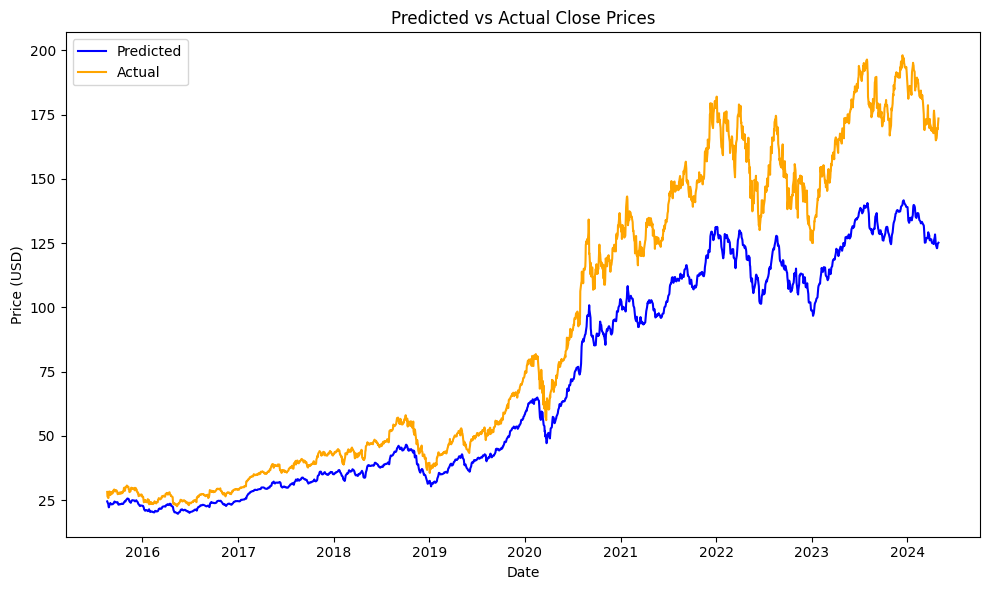

MSE: 732.1404597437939, RMSE: 27.058094163185142, MAE: 21.364822003338823, MAPE: 20.780558725677317, Direction Accuracy: 49.03934126258005%, R-squared: 0.7799978562386494


In [18]:
# Predict and evaluate
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predicted vs actual close prices using test data
plt.figure(figsize=(10,6))
plt.plot(data['Date'][split + 3:], predictions, label='Predicted', color='blue')
plt.plot(data['Date'][split + 3:], y_test, label='Actual', color='orange')
plt.title('Predicted vs Actual Close Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
direction_accuracy = (np.sign(y_test[1:] - y_test[:-1]) == np.sign(predictions[1:] - predictions[:-1])).mean()
r_squared = r2_score(y_test, predictions)

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, Direction Accuracy: {direction_accuracy*100}%, R-squared: {r_squared}')